# Climate Change Analysis 
* Student name: Chris Hollman
* Student pace: Self paced
* Scheduled review date/time: 
* Instructor name: Abhineet Kulkarni

## Project Overview
The goal of this project is to study the trends of our global climate. This will include an analysis of historical data, a prediction of future trends, and a regresssion model to determine associated factors. 

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [46]:
global_df = pd.read_csv('data/GlobalTemperatures.csv')
hist_gas_df = pd.read_csv('data/historical_emissions.csv')
gdp_df = pd.read_csv('data/gdp_growth.csv')
pop_df = pd.read_csv('data/world_population.csv')

## Initial Data Exploration for Timeseries
We will start with a timeseries model to identify trends and predict future temperatures. Later we will build some regression models to identify correlations with a number of other factors. For our purposes we will just focus on the global temperature dataset.

There are columns for both land and land/ocean min, max, and average temperatures. The ocean temperatures seem to have not been recorded until around l00 years later than land temps. 

In [3]:
#Converting time stamp column to datetime format
global_df['dt'] = pd.to_datetime(global_df['dt'])

In [4]:
print("lowest uncertainty:", global_df['LandAverageTemperatureUncertainty'].min())
print("highest uncertainty:", global_df['LandAverageTemperatureUncertainty'].max())

lowest uncertainty: 0.034
highest uncertainty: 7.88


There is an extremely large difference in uncertainty as recording methods have become more sophisticated. The highest uncertaintly is +/- 7.88 degrees Celcius (14.8 degrees Farenheit). I've decided to trim the least accurate quartile of data.

In [5]:
global_df['LandAverageTemperatureUncertainty'].describe()

count    3180.000000
mean        0.938468
std         1.096440
min         0.034000
25%         0.186750
50%         0.392000
75%         1.419250
max         7.880000
Name: LandAverageTemperatureUncertainty, dtype: float64

In [6]:
#as expected, the uncertainty values for earlier dates tend to be on the high side
global_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#more recent temperatures are accurate within +/- two tenths of a degree Farenheit
global_df.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


In [8]:
#determining the latest month with an uncertainty greater than cutoff threshold
global_df[global_df['LandAverageTemperatureUncertainty']>1.4].tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1155,1846-04-01,7.473,1.729,NaN,NaN,NaN,NaN,NaN,NaN
1166,1847-03-01,4.046,1.583,NaN,NaN,NaN,NaN,NaN,NaN
1177,1848-02-01,3.726,1.437,NaN,NaN,NaN,NaN,NaN,NaN
1237,1853-02-01,2.228,1.492,8.29,1.535,-3.213,1.783,13.362,0.457
1260,1855-01-01,2.522,1.465,8.22,1.099,-3.125,1.699,13.384,0.442


In [9]:
#dropping all dates prior to 1856(the last year in which every recorded temp was within desired uncertainty range)
global_df = global_df[global_df['dt'] >= '1856']

In [10]:
#converting temps the Farenheit for interpretability
global_df['y'] = global_df['LandAverageTemperature']*1.8+32
global_df.rename(columns = {'dt':'ds'}, inplace = True)

## Prophet Model
Since there are no other obvious cleaning or preperation needed for our remaining data, we can start with a simple, useful model using NeuralProphet. This model calls for there to be only two columns, one with the datetime values that needs to be named 'dt' and one with the temperature values which needs to be named 'y'

In [11]:
#dropping unneccessary columns and formatting for Neural Prophet
drop_columns = ['LandAverageTemperature',
                'LandAverageTemperatureUncertainty',
                'LandMaxTemperature',
                'LandMaxTemperatureUncertainty',
                'LandMinTemperature',
                'LandMinTemperatureUncertainty',
                'LandAndOceanAverageTemperature',
                'LandAndOceanAverageTemperatureUncertainty']
ts = global_df.drop(drop_columns, axis=1)
ts.head()

,ds,y
1272,1856-01-01,36.9680
1273,1856-02-01,36.0068
1274,1856-03-01,39.8696
1275,1856-04-01,45.9518
1276,1856-05-01,50.9540


In [12]:
#taking a small sampple to take an initial look at the data
temp_1990_2000 = ts[ts['ds'].between('1990-01-01','2000-01-01')]
X = temp_1990_2000['ds']
y = temp_1990_2000['y']

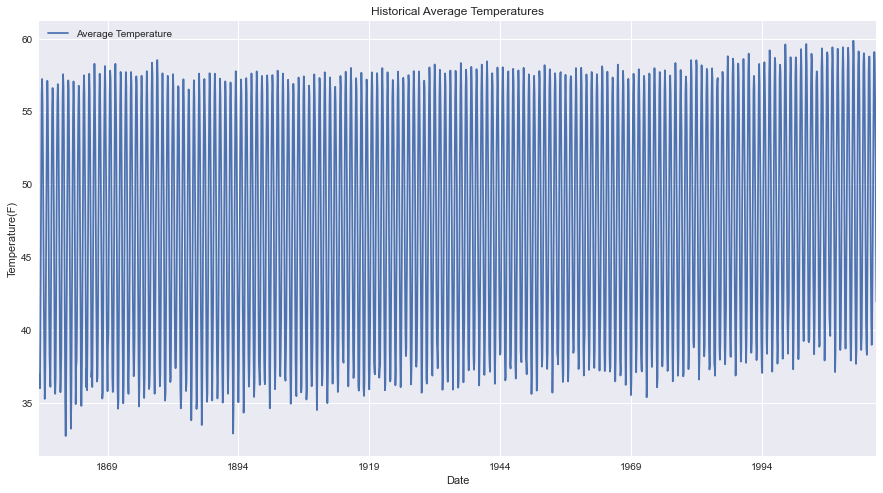

In [13]:
pd.plotting.register_matplotlib_converters()
ax = ts.set_index('ds').plot(figsize=(15, 8))
ax.set_title('Historical Average Temperatures')
ax.set_ylabel('Temperature(F)')
ax.set_xlabel('Date')
ax.legend(['Average Temperature']);

From this broad vikew, we can see that there is an slight overall upward trend. As expected there is yearly seasonality that the model should automatically pick up on.

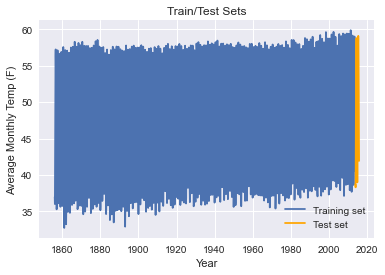

In [14]:
#splitting off last 2 years of data as a test set

ts_train = ts[ts['ds'] < pd.Timestamp('2014-01-01')]
ts_test = ts[ts['ds'] >= pd.Timestamp('2014-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(ts_train['ds'], ts_train['y'], label='Training set')
plt.plot(ts_test['ds'], ts_test['y'], label='Test set', color='orange')
plt.xlabel('Year')
plt.ylabel('Average Monthly Temp (F)')
plt.legend();

In [15]:
#checking test set dates
ts_test

,ds,y
3168,2014-01-01,38.7176
3169,2014-02-01,38.3000
3170,2014-03-01,43.4804
3171,2014-04-01,49.2602
3172,2014-05-01,54.6476
3173,2014-06-01,57.8030
3174,2014-07-01,58.7714
3175,2014-08-01,58.7750
3176,2014-09-01,55.5638
3177,2014-10-01,50.5940


## Intitial Modeling
The next step is to fit a NeuralProphet model to the timeseries. For the baseline model the only parameters we'll pass will be to prioritize MAE as the preferred metric to optimize. Once used to predict the test set, the model will return a validation MAE score as well as the components (trend and seasonality) applied to make the predictions. If the resulting MAE score is satisfactory, we can then broadcast those prediction out for future forecasts. For something as gradual as global temperature averages, we will try a longer term forecast of 30 years.

In [16]:
#fitting 'vanilla' NeuralProphet with MAE as loss function. 
m1 = NeuralProphet(loss_func='MAE')
m1.fit(ts_train, validation_df=ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.49E-02, min: 1.19E+00


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.49E-02, min: 6.33E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.65E-02
Epoch[160/160]: 100%|█| 160/160 [00:06<00:00, 24.43it/s, L1Loss=0.0193, MAE=0.48


,L1Loss,MAE,RMSE,Loss,RegLoss,L1Loss_val,MAE_val,RMSE_val
0,0.813826,20.385373,26.469987,0.609593,0.0,0.742299,18.593712,22.630457
1,0.725636,18.176317,24.073814,0.542830,0.0,0.668378,16.742059,20.388597
2,0.631163,15.809886,21.575356,0.471720,0.0,0.581388,14.563079,17.870462
3,0.524227,13.131269,18.450394,0.392207,0.0,0.479483,12.010463,14.828632
4,0.401685,10.061727,14.536895,0.300894,0.0,0.380247,9.524734,11.706913
...,...,...,...,...,...,...,...,...
155,0.019412,0.486254,0.635710,0.014165,0.0,0.347378,8.701411,10.742516
156,0.019458,0.487400,0.636689,0.014169,0.0,0.347344,8.700539,10.741731
157,0.019337,0.484374,0.636423,0.014090,0.0,0.347285,8.699081,10.739705
158,0.019294,0.483303,0.635900,0.014064,0.0,0.347431,8.702720,10.744449


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


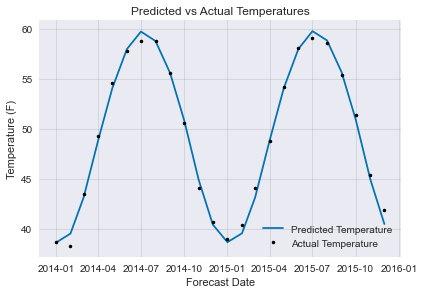

In [17]:
forecast1 = m1.predict(ts_test)
ax = plt.subplot()
plot= m1.plot(forecast1, ax = ax)
ax.set_title('Predicted vs Actual Temperatures')
ax.set_xlabel('Forecast Date')
ax.set_ylabel('Temperature (F)')
ax.legend(['Predicted Temperature', 'Actual Temperature']);

In [18]:
forecast1

,ds,y,residual1,yhat1,trend,season_yearly
0,2014-01-01,38.7176,-0.081991,38.635609,49.402252,-10.766644
1,2014-02-01,38.3000,1.251186,39.551186,49.406120,-9.854935
2,2014-03-01,43.4804,-0.314636,43.165764,49.409615,-6.243849
3,2014-04-01,49.2602,-0.368431,48.891769,49.413483,-0.521714
4,2014-05-01,54.6476,-0.564302,54.083298,49.417229,4.666068
5,2014-06-01,57.8030,0.183595,57.986595,49.421101,8.565491
6,2014-07-01,58.7714,0.971085,59.742485,49.424843,10.317642
7,2014-08-01,58.7750,0.020609,58.795609,49.428715,9.366896
8,2014-09-01,55.5638,0.032544,55.596344,49.432587,6.163758
9,2014-10-01,50.5940,0.269865,50.863865,49.436329,1.427537


In [19]:
mean_absolute_error(forecast1['y'], forecast1['yhat1'])

0.46318967819213935

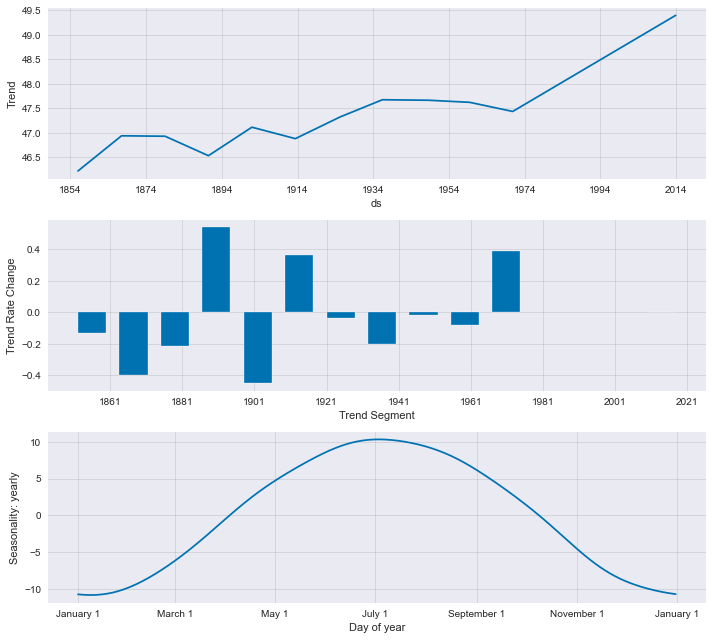

In [20]:
params = m1.plot_parameters()

## Model Interpretation
This model is performing very well with a MAE of 0.46. It is important to remember that it is only predicting one month into the future. In other words, it's unlikely that the forecast based on this data will be within .5 degrees when predicting the long term future. The only parameter I'd like to tweak is changepoint range, which is set at .8 by default, meaning that the model will not pick up on any change in trend in the last 20% of data, or around th 1970's. If you look at the trend portion of the parameters plot, this is where a significant upward trend begins. Before predicting future values, we will include all but the last 10%, identify whether this decreases the MAE, and then use the best performing parameters to predict future temperatures. 

In [21]:
m2 = m1 = NeuralProphet(loss_func='MAE', changepoints_range =.9)
m2.fit(ts_train, validation_df=ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.94E-01, min: 6.33E-01


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.67E-02, min: 7.42E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[160/160]: 100%|█| 160/160 [00:06<00:00, 24.93it/s, L1Loss=0.0194, MAE=0.48


,L1Loss,MAE,RMSE,Loss,RegLoss,L1Loss_val,MAE_val,RMSE_val
0,0.898576,22.508244,28.353613,0.655858,0.0,0.885119,22.171159,28.149633
1,0.769759,19.281533,24.901720,0.557318,0.0,0.764485,19.149418,24.944351
2,0.621914,15.578209,21.015347,0.443918,0.0,0.653942,16.380471,21.374845
3,0.481943,12.072102,17.005576,0.340160,0.0,0.569882,14.274868,18.149281
4,0.365067,9.144499,13.388630,0.251987,0.0,0.467382,11.707361,14.617256
...,...,...,...,...,...,...,...,...
155,0.019545,0.489581,0.641828,0.014214,0.0,0.347341,8.700480,10.741143
156,0.019474,0.487804,0.637931,0.014173,0.0,0.347235,8.697811,10.737794
157,0.019452,0.487247,0.639134,0.014130,0.0,0.347101,8.694463,10.733913
158,0.019383,0.485515,0.636902,0.014081,0.0,0.347229,8.697658,10.737741


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


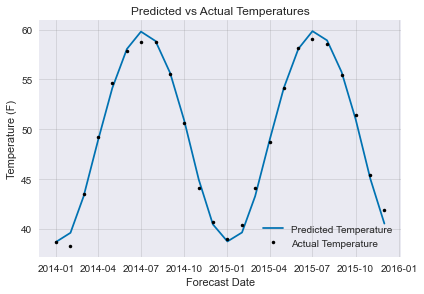

In [22]:
forecast2 = m2.predict(ts_test)
ax = plt.subplot()
plot= m2.plot(forecast2, ax = ax)
ax.set_title('Predicted vs Actual Temperatures')
ax.set_xlabel('Forecast Date')
ax.set_ylabel('Temperature (F)')
ax.legend(['Predicted Temperature', 'Actual Temperature']);

In [23]:
mean_absolute_error(forecast2['y'], forecast2['yhat1'])

0.451843338012696

## Second Model Interpretation/Predictions
Since this parameter change resulted in better scores, we will use this model to predict future global temperatures. Since global temperature change is seems to occur over longer timespans, we will have our model predict temps over the next 30 years.  

In [24]:
future_dates = m2.make_future_dataframe(periods = 360, df = ts_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [25]:
forecast_future = m2.predict(future_dates)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


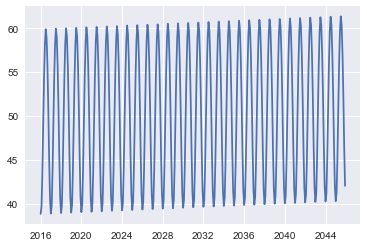

In [26]:
plt.plot(forecast_future['ds'], forecast_future['yhat1']);

In [27]:
forecast_future.groupby(pd.Grouper(key="ds", freq="Y")).mean()

,yhat1,trend,season_yearly
ds,,,
2016-12-31,49.545676,49.588201,-0.042526
2017-12-31,49.601686,49.638795,-0.037109
2018-12-31,49.652024,49.689366,-0.037341
2019-12-31,49.702364,49.739936,-0.037572
2020-12-31,49.748098,49.790623,-0.042526
2021-12-31,49.804108,49.841217,-0.037109
2022-12-31,49.854447,49.891788,-0.037341
2023-12-31,49.904786,49.942358,-0.037572
2024-12-31,49.950520,49.993045,-0.042526


## Forecast Summary
The final Prophet model suggests that global average temperatures will increase by another 1.5 degrees over the next 30 years. This is roughly on par with the predictions from the U.S. Global Change Research Program's 2016 Climate Science Special Report, which predicts an increase of 2 to 4 degrees by mid 21st century (2036-2065), depending on a number of factors.

## LSTM Model
Next we will apply and LSTM (Long Short Term Memory) Model to the same timeseries data. This is a bit more involved than Prophet, which automates many of the following steps. 
1) This model requires a slightly different datafram structure than our Prophet model (DateTime Index)
2) Resplitting into 2 year test set
3) Scaling the data (happens automatically with prophet)

In [28]:
lstm_df = ts.set_index('ds')
lstm_df.head()

,y
ds,
1856-01-01,36.9680
1856-02-01,36.0068
1856-03-01,39.8696
1856-04-01,45.9518
1856-05-01,50.9540


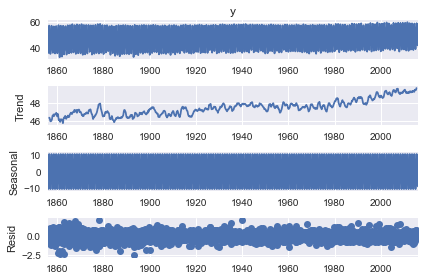

In [29]:
results = seasonal_decompose(lstm_df['y'])
results = results.plot()

We can see the same general trend that the prophet model picked up on. The seasonality is tougher to make out but has been well covered earlier in the notebook as well. We do not need to check for stationarity, as these more complex models don't require a stationary dataset. 

In [30]:
lstm_train = lstm_df[lstm_df.index < pd.Timestamp('2014-01-01')]
lstm_test = lstm_df[lstm_df.index >= pd.Timestamp('2014-01-01')]

In [31]:
scaler = MinMaxScaler()
scaler.fit(lstm_train)
train_scaled = scaler.transform(lstm_train)
test_scaled = scaler.transform(lstm_test)

In [32]:
n_input = 12
n_features = 1 
generator = TimeseriesGenerator(train_scaled, train_scaled, length = n_input, batch_size = 1)

In [33]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

Metal device set to: Apple M1


2022-11-15 12:23:38.797262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 12:23:38.797393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
#model.fit(generator, epochs=35)

Epoch 1/35


2022-11-15 12:23:43.490820: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 12:23:43.991017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1884/1884 [==============================] - 217s 115ms/step - loss: 0.0755
Epoch 2/35
1884/1884 [==============================] - 219s 116ms/step - loss: 0.0367
Epoch 3/35
1884/1884 [==============================] - 222s 118ms/step - loss: 0.0319
Epoch 4/35
1884/1884 [==============================] - 222s 118ms/step - loss: 0.0293
Epoch 5/35
1884/1884 [==============================] - 225s 120ms/step - loss: 0.0278
Epoch 6/35
1884/1884 [==============================] - 235s 125ms/step - loss: 0.0255
Epoch 7/35
1884/1884 [==============================] - 233s 124ms/step - loss: 0.0245
Epoch 8/35
1884/1884 [==============================] - 237s 126ms/step - loss: 0.0243
Epoch 9/35
1884/1884 [==============================] - 235s 125ms/step - loss: 0.0236
Epoch 10/35
1884/1884 [==============================] - 237s 126ms/step - loss: 0.0250
Epoch 11/35
1884/1884 [==============================] - 251s 133ms/step - loss: 0.0228
Epoch 12/35
1884/1884 [=============================

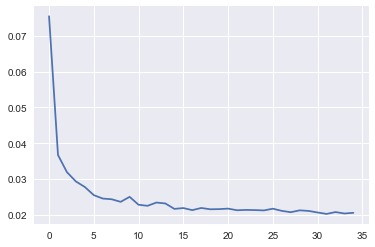

In [37]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [39]:
last_train_batch = train_scaled[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [40]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 435ms/step


2022-11-16 09:12:09.139352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.19550672]], dtype=float32)

In [41]:
test_scaled[0]

array([0.22071893])

In [120]:
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(lstm_test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 22ms/step


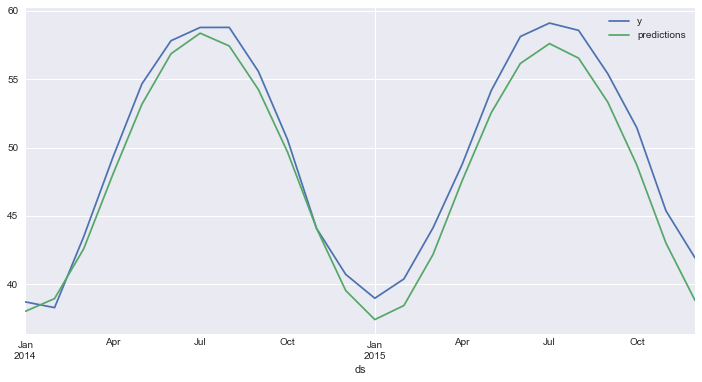

In [51]:
final_predictions = scaler.inverse_transform(test_predictions)
lstm_test['predictions'] = final_predictions
lstm_test.plot(figsize=(12,6)); 

In [52]:
mean_absolute_error(lstm_test['y'], lstm_test['predictions'])

1.4636002787657116

## Cleaning/Preprocessing Regression DataFrames
The last step in this project will be to run a regression model that takes possible contributers to climate change into account.

In [53]:
temp_year_df = ts.groupby(pd.Grouper(key="ds", freq="Y")).mean().reset_index()
temp_year_df['ds'] = temp_year_df['ds'].dt.year

In [54]:
temp_year_df.set_index('ds', inplace = True)
temp_year_df.head()

,y
ds,
1856,46.39265
1857,45.96470
1858,46.58045
1859,46.85360
1860,46.32950


In [55]:
drop_columns = ['Country', 'Sector','Data source', 'Gas', 'Unit']
gas_df = hist_gas_df[hist_gas_df['Country'] == 'World'].drop(columns = drop_columns).transpose()
gas_df.index = pd.to_datetime(gas_df.index)
gas_df.index = gas_df.index.year
gas_df.head()

,0
2018,36441.55
2017,35588.70
2016,35160.60
2015,34521.91
2014,34558.59


In [56]:
pop_df = pop_df[pop_df['Entity'] == 'World']
pop_df = pop_df[pop_df['Year'].between(1990,2018)]

In [57]:
pop_drop_cols = ['Code', 'Entity']
pop_df = pop_df.drop(columns=pop_drop_cols).set_index('Year')

In [58]:
gdp_df.head()

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863,4.198232,0.300000,5.700001,2.100000,1.999999,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.972652,4.308370,3.986754,2.925591,2.019391,2.542298,2.475272,2.077898,-2.939186,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.752287,5.600745,2.724543,1.451315,2.260314,2.647003,1.189228,3.911603,-2.351101,NaN
3,Africa Western and Central,AFW,NaN,1.848719,3.770212,7.272501,5.396356,4.049794,-1.787094,-9.546521,...,5.142964,6.104241,5.927350,2.745937,0.127595,2.318042,2.952230,3.190336,-0.884981,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.542188,4.954545,4.822628,0.943572,-2.580050,-0.147213,-2.003630,-0.624644,-5.399987,NaN


In [59]:
gdp_drop_columns = ['Code', 'Country Name']
world_gdp = gdp_df[gdp_df['Country Name'] == "World"].drop(columns=gdp_drop_columns).transpose()
world_gdp = world_gdp.dropna()
world_gdp.index = pd.to_datetime(world_gdp.index)
world_gdp.index = world_gdp.index.year
world_gdp.head()

,259
1961,3.800832
1962,5.320280
1963,5.192421
1964,6.568749
1965,5.555097


In [60]:
reg_df = pop_df.join(world_gdp).join(gas_df).join(temp_year_df)

mapping = {
     reg_df.columns[0]:'Population', 
     reg_df.columns[1]: 'GDP_Growth', 
     reg_df.columns[2]:'Emissions', 
     reg_df.columns[3]: 'Average_Temp'
}

reg_df.rename(columns = mapping, inplace=True)
reg_df.reset_index(inplace=True)

In [117]:
reg_df = reg_df.dropna()
reg_df.head()

,Year,Population,GDP_Growth,Emissions,Average_Temp
0,1990,5316175872,2.876178,22849.92,48.62150
1,1991,5406245888,1.446386,23056.40,48.52295
2,1992,5492686336,2.056186,22988.29,47.90585
3,1993,5577433600,1.808395,23124.00,47.95985
4,1994,5660727808,3.296975,23260.29,48.26975


In [80]:
X = reg_df.drop('Average_Temp', axis=1)
y = reg_df['Average_Temp']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .15)

In [101]:
boost = XGBRegressor()
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [2,3,4],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 1],
    'n_estimators': [50,100,150]
}

In [104]:
grid_boost = GridSearchCV(
    boost, 
    param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=3, 
    n_jobs=1)
grid_boost.fit(X_train, y_train)

best_parameters = grid_boost.best_params_

for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_boost.predict(X_train)
test_preds = grid_boost.predict(X_test)
training_MAE = mean_absolute_error(y_train, training_preds)
test_MAE = mean_absolute_error(y_test, test_preds)

print('')
print('Training MAE:' ,training_MAE)
print('Validation MAE:' ,test_MAE)

learning_rate: 0.1
max_depth: 4
min_child_weight: 2
n_estimators: 150
subsample: 1

Training MAE: 0.008427718561344348
Validation MAE: 0.21019504394531374


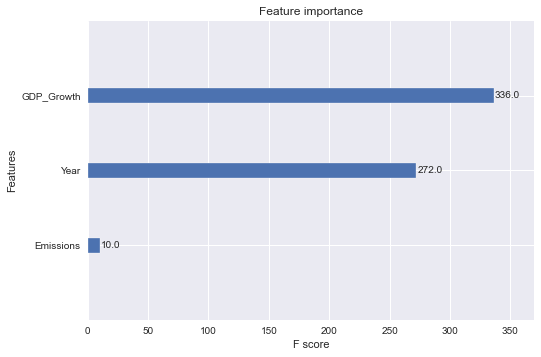

In [122]:
final_XGB = XGBRegressor(learning_rate=.1, 
                         max_depth=4, 
                         min_child_weight=2, 
                         n_estimators=150, 
                         subsample=1)
final_XGB.fit(X_train, y_train);
xgboost.plot_importance(final_XGB);